<>:17: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:17: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\media\AppData\Local\Temp/ipykernel_15740/3828255057.py:17: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if x_disc is 'exact':


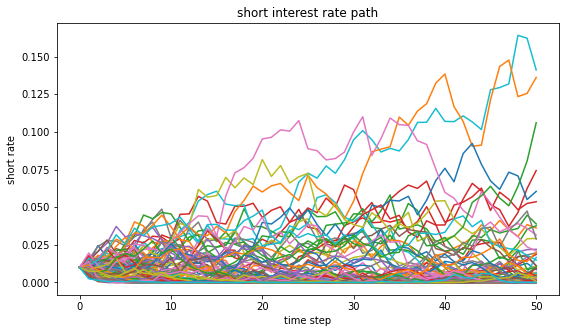

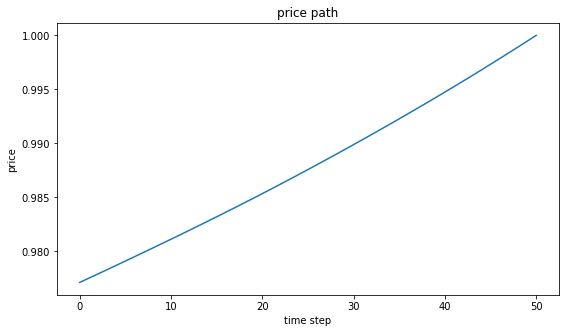

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

def CIR_generate_path(x0, T, M, I, kappa, theta, sigma, x_disc='exact'):
    dt = T / M
    x = np.zeros((M+1, I), dtype=np.float)
    x[0] = x0
    # same shape with zeros
    xh = np.zeros_like(x)
    xh[0] = x0

    
    ran = np.random.standard_normal((M + 1, I))

    if x_disc is 'exact':
      
        d = 4 * kappa * theta / sigma ** 2 
        # math.exp(x): e^x
        # c: coefficient before chi-squared distributed random variable
        c = (sigma ** 2 * (1 - math.exp(-kappa * dt))) / (4 * kappa) 
        if d > 1:
            for t in range(1, M + 1):
                l = x[t - 1] * math.exp(-kappa * dt) / c
                # chi: chi-squared distributed random variable; shape: 1 * I
                chi = np.random.chisquare(d - 1, I) 
                x[t] = c * ((ran[t] + np.sqrt(l)) ** 2 + chi)
        else:
            for t in range(1, M + 1):
                l = x[t - 1] * math.exp(-kappa * dt) / c
                N = np.random.poisson(l / 2, I)
                chi = np.random.chisquare(d + 2 * N, I)
                x[t] = c * chi
    #低精度模拟
    else:
        for t in range(1, M + 1):
            xh[t] = (xh[t - 1] + kappa * (theta - np.maximum(0, xh[t - 1])) * dt + \
                     np.sqrt(np.maximum(0, xh[t - 1])) * sigma * ran[t] * math.sqrt(dt))
            x[t] = np.maximum(0, xh[t])
    return x

'''Compute interest rate(r) path'''
def plot_paths(r):
    plt.figure(figsize=(9, 5))
    plt.plot(range(len(r)), r[:, :])
    plt.xlabel('time step')
    plt.ylabel('short rate')
    plt.title('short interest rate path')
    plt.show()


'''Pricing by r path'''
def zcb_estimator(r, T, I, M, x_disc='exact'):
    dt = T / M
    # Get r path
    zcb = np.zeros((M + 1, I), dtype=np.float)
    zcb[-1] = 1.0  # final value
    # Discount
    for t in range(M, 0, -1):
        zcb[t - 1] = zcb[t] * np.exp(-(r[t] + r[t - 1]) / 2 * dt)
    # Get average price
    return np.sum(zcb, axis=1) / I


if __name__ == "__main__":
    # Set some parameters
    r0, kappa_r, theta_r, sigma_r = [0.01, 0.1, 0.03, 0.2]
    T = 2.0  # time length
    M = 50  # time steps
    dt = T / M  # minimum unit of time

    # Get r path and plot it
    I = 100  # number of MCS paths
    r = CIR_generate_path(r0, T, M, I, kappa_r, theta_r, sigma_r)
    plot_paths(r)

    # Get r path and use exact method to discount to price
    I = 50000  # number of MCS paths
    r = CIR_generate_path(r0, T, M, I, kappa_r, theta_r, sigma_r)

    price_exact = zcb_estimator(r, T, I, M)
    plt.figure(figsize=(9, 5))
    plt.plot(range(len(price_exact)), price_exact)
    plt.xlabel('time step')
    plt.ylabel('price')
    plt.title('price path')
    plt.show()